In [1]:
# %config Completer.use_jedi = False
#Updating model size

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/MyDrive')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [4]:
!pip3 install Box2D
!pip3 install box2d-py
# !pip3 uninstall gym[all]
!pip3 install gym[Box_2D]


In [5]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import defaultdict ,namedtuple

In [6]:
print(torch.cuda.is_available())


True


In [7]:
import time

In [8]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('Environment shape:',env.observation_space.shape)
print('Action space shape:',env.action_space.n)
state=env.reset()
print('Initial random state:',state)
state_space=env.observation_space.shape
action_space=env.action_space.n

Environment shape: (8,)
Action space shape: 4
Initial random state: [-5.9156417e-04  1.4134574e+00 -5.9935719e-02  1.1277095e-01
  6.9228926e-04  1.3576316e-02  0.0000000e+00  0.0000000e+00]


#### The state space is as follows:<br>
<ul>
<li>pos.x - x-coordinate of the lander # raw input. This variable is transformed during the state creation</li>
<li>pos.y - y-coordinate of the lander # raw input. This variable is transformed during the state creation</li>
<li>vel.x - velocity of lander along x axis # raw input. This variable is transformed during the state creation</li>
<li>vel.y - velocity of lander along y axis # raw input. This variable is transformed during the state creation</li>
<li>self.lander.angle - angle of the lander # raw input. This variable is transformed during the state creation</li>
<li>self.lander.angularVelocity - angular velocity of the lander # raw input. This variable is transformed during the state creation</li>
<li>self.legs[0].ground_contact - if leg 0 of the lander is in contact with the ground # raw input. This variable is transformed during the state creation</li>
<li>self.legs[1].ground_contact - if leg 1 of the lander is in contact with the ground # raw input. This variable is transformed during the state creation</li>
</ul>

#### The action space is as follows:
[Don't fire engines, fire left engine, main engine, right engine]


In [9]:
class DNN(nn.Module):
    def __init__(self,input_size, output_size,hidden_size1=800, hidden_size2=200):
        super().__init__()
        self.Lin1=nn.Linear(input_size,hidden_size1)
        self.Lin2=nn.Linear(hidden_size1,hidden_size2)
        self.Lin3=nn.Linear(hidden_size2,output_size)
        
    def forward(self,X):
        X=F.relu(self.Lin1(X))
        X=F.relu(self.Lin2(X))
        X=self.Lin3(X)
        return X

In [10]:
class ReplayBuffer():
    def __init__(self,batch_size=128,size=int(5e4)):
        self.buffer_size=size
        self.batch_size=batch_size
        self.buffer=[]
        self.step=namedtuple('step',field_names=['state', 'action', 'reward', 'next_state', 'done']) #from https://stackoverflow.com/a/43404344 to reduce memory size
        self.states=[]
        self.actions=[]
        self.rewards=[]
        self.next_states=[]
        self.terminal=0
        self.counter=0 #count total number of items in the buffer
    
    def add_item(self, state, action, reward,next_state,done):
        st=self.step(state,action,reward,next_state, done)
        if self.counter<self.buffer_size:
            self.buffer.append(st)
        else:
            i=(self.counter+1)%self.buffer_size
            self.buffer[i]=st
        self.counter+=1

    def sample(self):
        np.random.seed(42)
        if len(self.buffer)<self.batch_size:
            print(f'Still needs to be populated: {len(self.buffer)} populated out of {self.batch_size}: {len(self.buffer)*100/self.batch_size}% complete')
        else:
            sample_idx=random.sample(self.buffer,self.batch_size)
            states_=torch.from_numpy(np.vstack([e.state for e in sample_idx if e is not None])).float().cuda()
            actions_=torch.from_numpy(np.vstack([e.action for e in sample_idx if e is not None])).long().cuda()
            rewards_=torch.from_numpy(np.vstack([e.reward for e in sample_idx if e is not None])).float().cuda()
            next_states_=torch.from_numpy(np.vstack([e.next_state for e in sample_idx if e is not None])).float().cuda()
            dones_=torch.from_numpy(np.vstack([e.done for e in sample_idx if e is not None]).astype(np.uint8)).float().squeeze().cuda()
        return (states_, actions_, rewards_, next_states_,dones_)     

In [11]:
torch.random.manual_seed(42)
pred_model=DNN(state_space[0],action_space).cuda()
target_model=DNN(state_space[0],action_space).cuda()

In [12]:
criterion = nn.MSELoss()
optimizer=torch.optim.Adam(pred_model.parameters(),lr=5e-4)

In [13]:
class DQNAgent():
    def __init__(self,env,buffer,dnn_pred,dnn_target,gamma=0.99,replace=500,epsilon=1):
        self.buffer=buffer
        self.pred_net=dnn_pred
        self.target_net=dnn_target
        self.replace_count=replace
        self.epsilon=epsilon
        self.gamma=gamma
        self.losses=[]
        
    def choose_action(self,env,state):
        if random.random()>self.epsilon:
            with torch.no_grad():
                state=torch.FloatTensor(state).cuda()
                action=torch.argmax(self.pred_net.forward(state)).item()
        else:
            action=env.action_space.sample()
        return action
        
    def step(self):
        states, actions, rewards, next_states,dones=self.buffer.sample()
        dones=dones.reshape(-1,1)
        acts = actions.squeeze().type(torch.int64).view(-1,1).cuda()#Get updates from buffer
        preds=self.pred_net.forward(states).squeeze().gather(-1,acts)
        #Forward pass to get predicted values for the training network ---- (1)
        target_q=torch.max(self.target_net.forward(next_states.float()),dim=1)[0].reshape(-1,1) #get max(Q(next_states)) for the target_q as the reference values
        targets=rewards+(self.gamma*target_q*(1-dones[0])).detach() # get TD update for max(Q[next_state]) 1-dones implies there should no q(next_state) or q_next state for terminal state=0 ---- (2)
        loss=criterion(preds,targets.view(-1,1))#Calculate MSE loss between (2) and (1)
        optimizer.zero_grad() #Initiate backpropogation
        loss.backward()  #Get backpropogation gradients
        optimizer.step() #Update weights
        return loss
    
    def update_target_weights(self):
        for pred, targ in zip(self.pred_net.parameters(), self.target_net.parameters()):
            targ.data.copy_(pred.data)

In [14]:
import time

In [15]:
def initiate_buffer(env,agent,episode_length=2): #Run a few episodes just to populate the buffer
    for epi in range(episode_length):          
        state = env.reset()
        action=env.action_space.sample()
        done=False
        while not done:
            next_state, rewards, done, info = env.step(action)
            agent.buffer.add_item(state, action, rewards, next_state,done)
    print(len(agent.buffer.buffer))

In [16]:
rep_buffer=ReplayBuffer()
agent=DQNAgent(env,rep_buffer,pred_model,target_model)

In [17]:
initiate_buffer(env,agent)

137


In [18]:
import time

In [19]:
episode_rewards=[]
episode_loss=[]
times=[]
episode_count=2000
counter_change=0
best_avg_reward=-np.inf
for epi in range(episode_count):## Introduce all resetting of parameters of epsilon here
    print('\rEpisode {}'.format(epi+1), end="")
    start=time.time()
    done=False
    state=env.reset()
    agent.epsilon=max(agent.epsilon*0.995,0.01)
    init_reward=0
    step=0
    while not done:
        action=agent.choose_action(env,state)
        next_state,reward,done,info=env.step(action)
        init_reward+=reward
        agent.buffer.add_item(state, action, reward, next_state,done)
        loss=agent.step()
        counter_change+=1
        if counter_change%agent.replace_count==0:
            agent.update_target_weights()
        state=next_state
        step+=1
    agent.terminal=next_state
    end=time.time()
    dur=end-start
    times.append(dur)
    episode_loss.append(loss)
    episode_rewards.append(init_reward)
    if (epi+1)%100==0:
        print(f'\n\nLoss for episode {epi+1}: {loss}')
        print(f'Duration for episode for {epi+1}:',dur)
        print(f'No. of steps for {epi+1}:',step)
        avg_rewards=np.mean(episode_rewards[-100:])
        print(f'Rewards for {epi+1}:', avg_rewards)
        print(f'Replay buffer length for {epi+1}:',len(agent.buffer.buffer))
        print('\n')
        if avg_rewards>=200:
          print(f'Target crossed: {best_avg_reward}')
          print('\n')
          torch.save(agent.pred_net.state_dict(), 'pred_model_weights_fit_large.pth')
          torch.save(agent.target_net.state_dict(), 'target_model_weights_fit_large.pth')
          if avg_rewards>best_avg_reward:
            print('Previous highest average reward crossed. New highest average reward is:',avg_rewards)
            best_avg_reward=avg_rewards
            torch.save(agent.pred_net.state_dict(), 'pred_model_weights_highest_large.pth')
            torch.save(agent.target_net.state_dict(), 'target_model_weights_highest_large.pth')
     

Episode 100

Loss for episode 100: 15489.640625
Duration for episode for 100: 0.41466522216796875
No. of steps for 100: 88
Rewards for 100: -164.28434374056764
Replay buffer length for 100: 9595


Episode 200

Loss for episode 200: 354.7332458496094
Duration for episode for 200: 1.433605670928955
No. of steps for 200: 277
Rewards for 200: -150.0215346564271
Replay buffer length for 200: 20758


Episode 300

Loss for episode 300: 110.87184143066406
Duration for episode for 300: 0.9315423965454102
No. of steps for 300: 191
Rewards for 300: -139.07658389338715
Replay buffer length for 300: 44864


Episode 400

Loss for episode 400: 10.810778617858887
Duration for episode for 400: 0.47698092460632324
No. of steps for 400: 96
Rewards for 400: -86.02751254774928
Replay buffer length for 400: 50000


Episode 500

Loss for episode 500: 1.625012993812561
Duration for episode for 500: 1.453779935836792
No. of steps for 500: 282
Rewards for 500: 130.9911416124317
Replay buffer length for 500: 500

In [20]:
import matplotlib.pyplot as plt

In [27]:
np.save('epside_rewards_large.txt',episode_rewards)
np.save('episode_loss_large.txt',episode_loss)
np.save('episode_duration_large.txt',times)

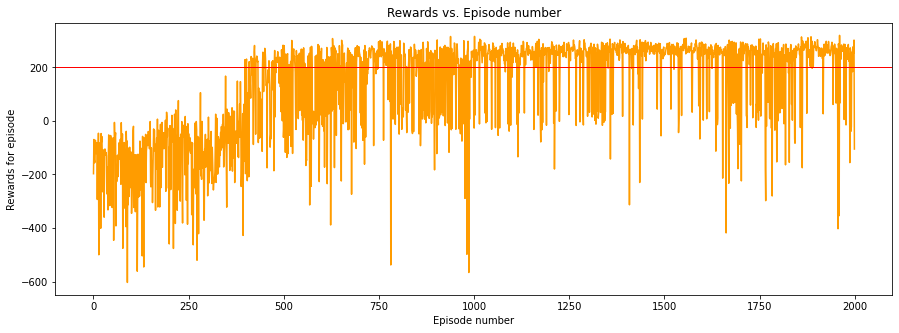

In [28]:
plt.figure(figsize=(15,5))
plt.plot(range(episode_count),episode_rewards,color='#ff9c00')
plt.axhline(y=200,linewidth=1,color='red')
plt.xlabel('Episode number')
plt.ylabel('Rewards for episode')
plt.title('Rewards vs. Episode number')
plt.show()



In [29]:
print('No. of episodes where the rewards crossed the threshold reward of 200 is:',(np.array(episode_rewards)>=200).sum())
print('% of episodes where the rewards crossed the threshold reward of 200 is:',(np.array(episode_rewards)>=200).sum()*100/len(episode_rewards),'%')

No. of episodes where the rewards crossed the threshold reward of 200 is: 1168
% of episodes where the rewards crossed the threshold reward of 200 is: 58.4 %


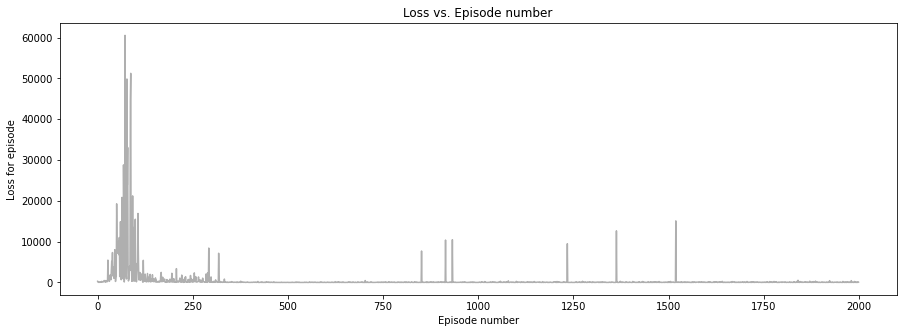

In [30]:
plt.figure(figsize=(15,5))
plt.plot(range(episode_count),episode_loss,color='#afafaf')
plt.xlabel('Episode number')
plt.ylabel('Loss for episode')
plt.title('Loss vs. Episode number')
plt.show()


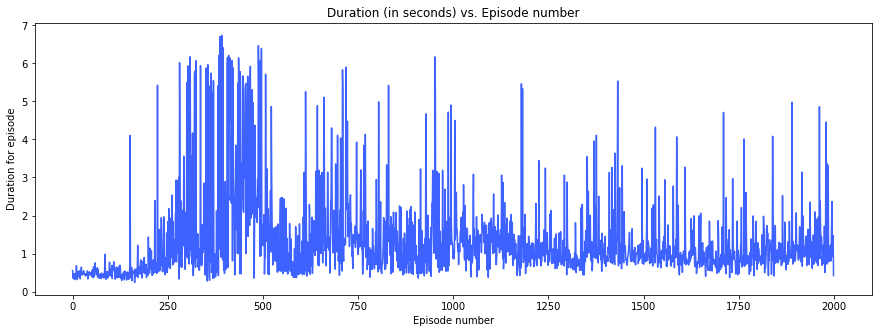

In [31]:
plt.figure(figsize=(15,5))
plt.plot(range(episode_count),times,color='#3e62ff')
plt.xlabel('Episode number')
plt.ylabel('Duration for episode')
plt.title('Duration (in seconds) vs. Episode number')
plt.show()

Hence,we are able to achieve the highest average reward of **260.6367** in the interval of 1980-1990 episodes. However, we cross the target of a reward of 200 **within 600 episodes**. 

Key areas of speed improvement came from:
Changing actions from float to long

1.   Changing index selection in random.sample() to object selection
2.   Trying to avoid a for loop in sample() destroyed my performance as I tried to convert to a numpy array to use range slicing
2.   Detach() the result tensor of q*(1-dones) from the gradient

Hyper parameters were taken from the Deep Reinforcement Learning git